In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from warnings import filterwarnings
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
import os
import matplotlib.pyplot as plt
import seaborn as sns

filterwarnings('ignore')


In [2]:
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer

sklearn.__version__

'0.20.3'

In [3]:
# Load data
do_sample = True
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

if do_sample:
    train = train.sample(frac=0.1, random_state=1)
    

print("train data shape", train.shape)
print("test data shape", test.shape)


train data shape (40066, 202)
test data shape (399335, 201)


In [4]:
# train["A_avg"] = (train["A_1"]+train["A_2"]) / 2
# for i in range(165):
#     train["XD_"+str(i+1)+str(i+2)] = (train["D_"+str(i+1)]+train["D_"+str(i+2)])/2 
    
# train.fillna(value=-1)
# test.fillna(value=-1)

# target_column = "target"
# id_column = "id"
# categorical_cols = [c for c in test.columns if test[c].dtype in [np.object]]
# numerical_cols = [c for c in test.columns if test[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
# print("Number of features", len(categorical_cols)+len(numerical_cols))


In [5]:
train_input = train.drop(['id','target','B_15'],axis = 1)
test_input  = test.drop(['id','B_15'],axis = 1)

train_labels = train['target']

app_train = pd.get_dummies(train_input)
app_test = pd.get_dummies(test_input)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(app_train)
train_imputed = imp_mean.transform(app_train)
test_imputed = imp_mean.transform(app_test)

scaler = StandardScaler()
scaler.fit(train_imputed)
train_imputed = scaler.transform(train_imputed)
test_imputed = scaler.transform(test_imputed)


In [6]:

features = list(app_train.columns)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train_imputed,train_labels)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


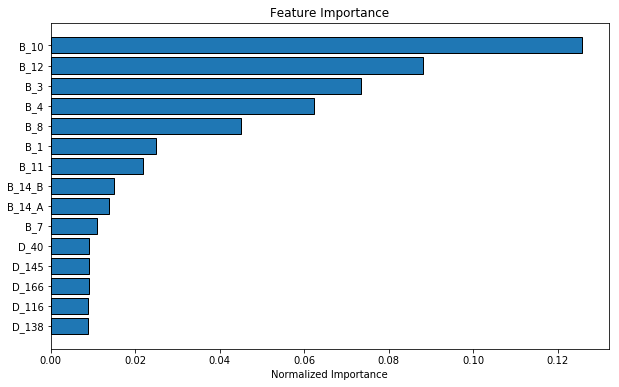

In [7]:
def plot_feature_importances(df):
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    
    return df
feature_importances_sorted = plot_feature_importances(feature_importances)

In [8]:
fe_threshold = 0.001
#print(feature_importances_sorted.query('importance_normalized>{}'.format(fe_threshold)))
selected_features = feature_importances_sorted.query('importance_normalized > {}'.format(fe_threshold))['feature'].values
print(selected_features)

['B_10' 'B_12' 'B_3' 'B_4' 'B_8' 'B_1' 'B_11' 'B_14_B' 'B_14_A' 'B_7'
 'D_40' 'D_145' 'D_166' 'D_116' 'D_138' 'D_56' 'D_142' 'D_34' 'D_66'
 'D_13' 'D_152' 'D_117' 'D_26' 'D_6' 'D_1' 'D_17' 'D_132' 'B_9' 'D_121'
 'B_13' 'D_154' 'B_2' 'D_120' 'B_5_B' 'D_162' 'D_29' 'D_78' 'D_85' 'D_35'
 'D_144' 'D_42' 'D_103' 'D_27' 'D_47' 'D_72' 'D_65' 'D_3' 'D_30' 'D_160'
 'D_140' 'D_14' 'D_141' 'D_50' 'C_14' 'D_146' 'D_163' 'D_71' 'D_159' 'C_8'
 'D_12' 'D_94' 'D_67' 'D_86' 'D_125' 'D_62' 'D_97' 'D_131' 'D_63' 'D_115'
 'D_101' 'D_164' 'D_126' 'D_96' 'D_128' 'D_165' 'D_139' 'D_37' 'D_70'
 'D_114' 'D_149' 'D_157' 'D_88' 'D_161' 'D_111' 'C_9' 'D_93' 'D_91'
 'D_100' 'D_44' 'D_16' 'D_18' 'D_124' 'C_12' 'D_89' 'D_108' 'D_31' 'D_143'
 'D_46' 'D_20' 'D_90' 'D_45' 'D_95' 'D_134' 'D_98' 'C_1' 'C_3' 'D_82'
 'D_135' 'D_137' 'D_57' 'D_130' 'D_28' 'D_11' 'D_48' 'D_64' 'C_11' 'D_39'
 'D_118' 'D_22' 'D_21' 'C_16' 'B_6_B' 'D_112' 'D_2' 'D_61' 'D_155' 'D_68'
 'D_127' 'D_19' 'D_76' 'D_129' 'D_158' 'D_69' 'D_49' 'D_7' 'D_

In [9]:
train_imputed= pd.DataFrame(train_imputed, columns = app_train.columns)
test_imputed= pd.DataFrame(test_imputed, columns= app_test.columns)
train=pd.concat([train_imputed[selected_features], pd.DataFrame({'target':train_labels})])
test=test_imputed[selected_features]
print(train.columns)

Index(['A_1', 'A_2', 'B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14_A', 'B_14_B',
       'B_2',
       ...
       'D_91', 'D_92', 'D_93', 'D_94', 'D_95', 'D_96', 'D_97', 'D_98', 'D_99',
       'target'],
      dtype='object', length=198)


In [10]:
target_column ='target'
id_column = 'id'
categorical_cols = [c for c in test.columns if test[c].dtype in [np.object]]
numerical_cols = [c for c in test.columns if test[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
preprocess = make_column_transformer(
    (numerical_cols, make_pipeline(SimpleImputer(), StandardScaler())),
    (categorical_cols, OneHotEncoder()))

In [11]:
column_transformer = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [ ]:
classifier_lgbm = make_pipeline(preprocess,LGBMClassifier(n_jobs=30,learning_rate=0.02,num_tree=100,lambda_l1=5,max_bin=512))
oof_pred_lgbm = cross_val_predict(classifier_lgbm, train, train[target_column],cv=5,method="predict_proba",n_jobs=-1,verbose=20)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


In [ ]:
classifier_xgb = make_pipeline(preprocess, XGBClassifier(n_jobs=30, nthreads=-1))
oof_pred_xgb = cross_val_predict(classifier_xgb, train, train[target_column],cv=5,method="predict_proba",n_jobs=-1,verbose=20)

In [ ]:
classifier_lr = make_pipeline(preprocess,LogisticRegression(n_jobs=30))
oof_pred_lr = cross_val_predict(classifier_lr, train, train[target_column],cv=5,method="predict_proba",n_jobs=-1,verbose=20)

In [ ]:
classifier_gnb = make_pipeline(preprocess, GaussianNB())
oof_pred_gnb = cross_val_predict(classifier_gnb, train, train[target_column],cv=5,method="predict_proba",n_jobs=30,verbose=20)

In [ ]:
#classifier_rf = make_pipeline(preprocess,RandomForestClassifier(random_state=42))
#oof_pred_rf = cross_val_predict(classifier_rf, train, train[target_column],cv=5,method="predict_proba",n_jobs=-1,verbose=20)

In [ ]:
#classifier_svm = make_pipeline(preprocess, svm.SVC(random_state=42))
#oof_pred_svm = cross_val_predict(classifier_svm, train, train[target_column],cv=5,method="predict_proba",n_jobs=-1,verbose=20)

In [ ]:
pred ={'target': train[target_column] ,'lgbm':oof_pred_lgbm[:,0], 'xgb':oof_pred_xgb[:,0], 'lr': oof_pred_lr[:,0], 'gnb':oof_pred_gnb[:,0]}
base_predictions = pd.DataFrame(pred)
corr = base_predictions.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [ ]:

voting_classifier = VotingClassifier(estimators=[
    ('lgbm', classifier_lgbm), 
    ('xgb', classifier_xgb), 
    ('lr',classifier_lr), 
    ('gnb', classifier_gnb)],
                 voting='soft', n_jobs=30)

In [ ]:
train = pd.read_csv("data/train.csv")
train=pd.concat([train_imputed[selected_features], pd.DataFrame({'target':train_labels})])
test=test_imputed[selected_features]
oof_pred = cross_val_predict(voting_classifier, train, train[target_column],cv=5,method="predict_proba",n_jobs=30,verbose=20)
print("Cross validation AUC {:.4f}".format(roc_auc_score(train[target_column], oof_pred[:,1])))

In [ ]:
voting_classifier.fit(train, train[target_column])

In [55]:
test_preds = voting_classifier.predict_proba(test)[:,1]
sub = pd.read_csv("data/sample_submission.csv")
sub[target_column] = test_preds
sub.to_csv("results/submit_results.csv", index=False)
print('done')

done


In [56]:
%%bash
kaggle competitions submit -c kaggledays-sf-hackathon -f results/submit_results.csv -m date

Successfully submitted to KaggleDays SF Hackathon

100%|██████████| 10.1M/10.1M [00:02<00:00, 4.09MB/s]
